In [37]:
import sys
from pathlib import Path
ROOT = Path.cwd().parent          
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

In [38]:
from analysis.models import Paper
from analysis.data_io import import_corpus
from analysis.forecast import proj_from_year_series
from analysis.counts import occurrence_freq_by_year, occurrences_by_year, occurences_by_word
from analysis.plots import plot_word_timeseries, plot_word_scatter
from analysis.lexicon import LLM_WORDS_EN

from pydantic import TypeAdapter
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
import matplotlib.pyplot as plt

In [39]:
papers = import_corpus(batch_size=100, streaming=False, url="julilili42/papers", adapter = TypeAdapter(list[Paper]))
rows = [(a.date.year, a.article) for a in papers]
year, articles = zip(*rows)

58419 articles to be loaded for dataset papers


In [ ]:
# distribution of articles for years
year_distribution = pd.Series(year).value_counts().sort_index()
# generate word matrix 
vec = CountVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b[a-z]{4,}\b",
    binary=True,
    max_features=200000
)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

Text(0, 0.5, 'Number of papers')

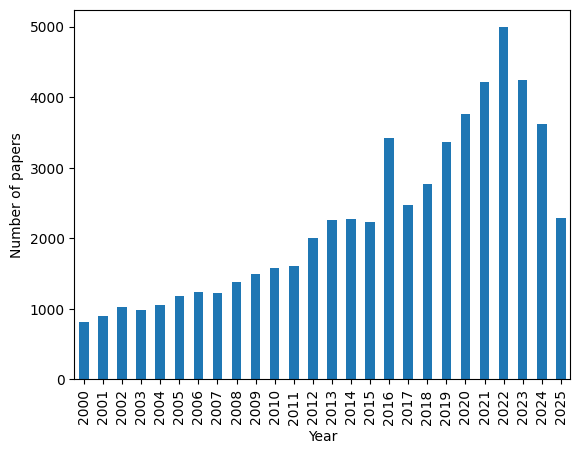

In [41]:
ax = year_distribution.plot(kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("Number of papers")

In [42]:
occurence_freq = occurrence_freq_by_year(year=year, word_matrix_bin=word_matrix_bin, vocab=vocab)
occurence_counts = occurrences_by_year(year=year, word_matrix=word_matrix_bin, vocab=vocab)

Goal: try to find words which disproportionaly increased in use, by interpolating use in year 2024 

- frequency gap $\delta = p - q$ $\implies$ highlights excess usage of frequent words
- frequency ratio $r = \frac{p}{q}$ $\implies$ highlights excess usage of infrequent words.

In [43]:
eps = 1e-9
min_q = 5e-4
min_p = 5e-3

train = occurence_freq.loc[2000:2021]
train_baseline = train.mean()

p = occurence_freq.loc[2024]
q = occurence_freq.loc[:2022].apply(proj_from_year_series, axis=0)

# metrics
delta = p - q
ratio = p / np.maximum(q, eps)
growth = np.log((p + eps) / (train_baseline + eps))

metrics_df = pd.DataFrame({"p": p, "q": q, "delta": delta, "ratio": ratio, "growth": growth})

min_q = 5e-4
min_p = 5e-3
mask_ratio = (metrics_df["q"] > min_q) & (metrics_df["p"] > min_p)
excess = metrics_df.loc[mask_ratio]


In [44]:
# Number of papers in 2024 (to estimate variance)
N2024 = int(pd.Series(year).value_counts().sort_index().loc[2024])

# z = (p - q) / sqrt( q*(1-q)/N )
var = np.maximum(q * (1.0 - q) / max(N2024, 1), eps)
z_gap = (p - q) / np.sqrt(var)

# Log-Ratio
log_ratio = np.log((p + eps) / (q + eps))

# LLM Shift Index
use_gap = (q > min_q) & (p > min_p)
idx_llm_shift = np.where(use_gap, z_gap, log_ratio)
idx_llm_shift = pd.Series(idx_llm_shift, index=p.index, name="llm_shift")

shift_metrics = metrics_df.assign(
    log_ratio=log_ratio,
    z_gap=z_gap,
    llm_shift=idx_llm_shift,
).sort_values("llm_shift", ascending=False)

In [45]:
shift_metrics.head(20)

,p,q,delta,ratio,growth,log_ratio,z_gap,llm_shift
2023,0.037241,0.001203,0.036039,3.096799e+01,4.707949,3.432953,62.607923,62.607923
2022,0.033103,0.001595,0.031509,2.075586e+01,4.845831,3.032828,47.540399,47.540399
emphasizing,0.009103,0.000532,0.008572,1.712359e+01,1.988064,2.840455,22.389105,22.389105
ordering,0.006897,0.000532,0.006365,1.297241e+01,1.238300,2.562823,16.624814,16.624814
ai,0.015724,0.002392,0.013332,6.572690e+00,2.607109,1.882923,16.430502,16.430502
contentheadercolor,0.005793,0.000000,0.005793,5.793103e+06,4.088651,15.572179,183.194016,15.572179
underscoring,0.005793,0.000000,0.005793,5.793103e+06,2.541599,15.572179,183.194016,15.572179
leveraged,0.004966,0.000000,0.004966,4.965517e+06,3.200124,15.418028,157.023442,15.418028
transformer,0.004138,0.000000,0.004138,4.137931e+06,3.767380,15.235707,130.852869,15.235707
forcings,0.003862,0.000000,0.003862,3.862069e+06,3.565096,15.166714,122.129344,15.166714


In [46]:
import spacy
# german    de_core_news_lg
# english   en_core_web_lg
nlp = spacy.load("en_core_web_lg")

words = list(excess.index)
pos_tags = {}
for doc in nlp.pipe(words, batch_size=500):
    token = doc[0]
    pos_tags[token.text] = token.pos_

allowed_pos = {"ADJ", "VERB", "ADV"}
style_words = [w for w, pos in pos_tags.items() if pos in allowed_pos]

excess_style_words = excess.loc[excess.index.isin(style_words)].sort_values("growth", ascending=False)

In [47]:
excess_style_words

,p,q,delta,ratio,growth
leveraging,0.011310,0.002215,0.009095,5.105335,2.742784
underscores,0.012690,0.004987,0.007702,2.544418,2.670286
paleoclimate,0.006621,0.003190,0.003431,2.075586,2.649047
ai,0.015724,0.002392,0.013332,6.572690,2.607109
leverages,0.005241,0.003392,0.001849,1.545055,2.504609
...,...,...,...,...,...
describes,0.005517,0.025457,-0.019939,0.216731,-0.816545
probably,0.007448,0.019823,-0.012375,0.375733,-0.874455
seems,0.009655,0.015949,-0.006294,0.605379,-0.886685
hope,0.005241,0.012810,-0.007569,0.409150,-0.935679


In [48]:
found_llm_words = [w for w in LLM_WORDS_EN if w in excess.index]

llm_in_df = excess.loc[excess.index.isin(found_llm_words)]

llm_in_df.sort_values("growth", ascending=False).head(20)

,p,q,delta,ratio,growth
underscores,0.012690,0.004987,0.007702,2.544418,2.670286
leverages,0.005241,0.003392,0.001849,1.545055,2.504609
notable,0.009103,0.011367,-0.002263,0.800878,1.699254
crucially,0.009103,0.003721,0.005382,2.446227,1.556521
notably,0.028138,0.022621,0.005517,1.243898,1.334156
emphasize,0.012414,0.005633,0.006780,2.203617,1.215772
valuable,0.035586,0.023267,0.012319,1.529478,1.157504
foster,0.007172,0.004785,0.002388,1.499034,1.142950
landscape,0.013241,0.010862,0.002380,1.219099,1.117943
tailored,0.010207,0.012013,-0.001806,0.849657,1.073800


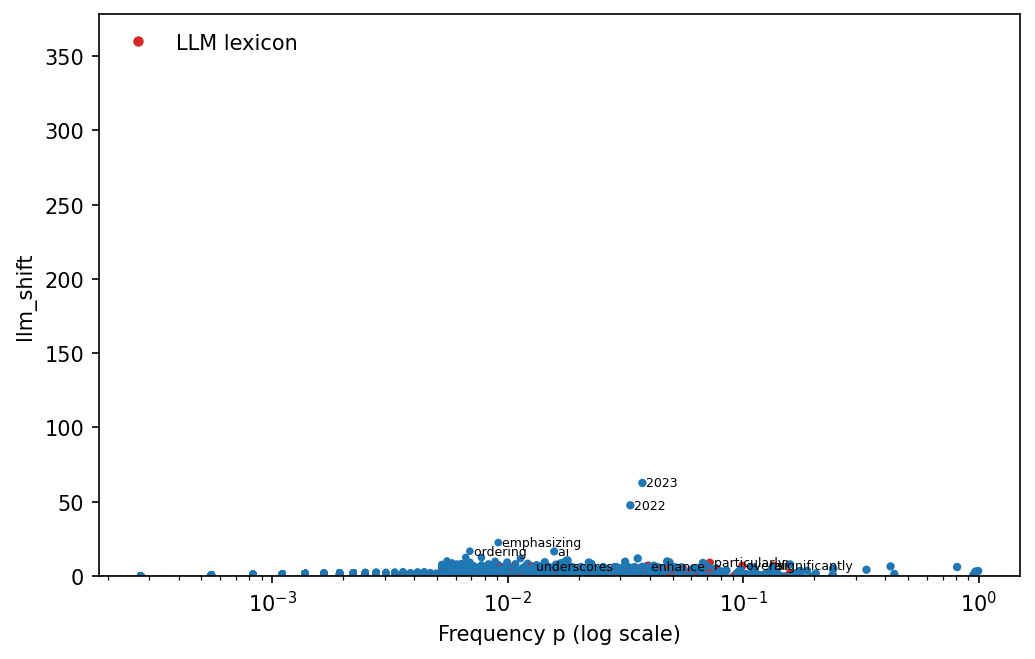

In [49]:
plot_word_scatter(
    shift_metrics, 
    metric="llm_shift",
    llm_words=set(LLM_WORDS_EN),
)

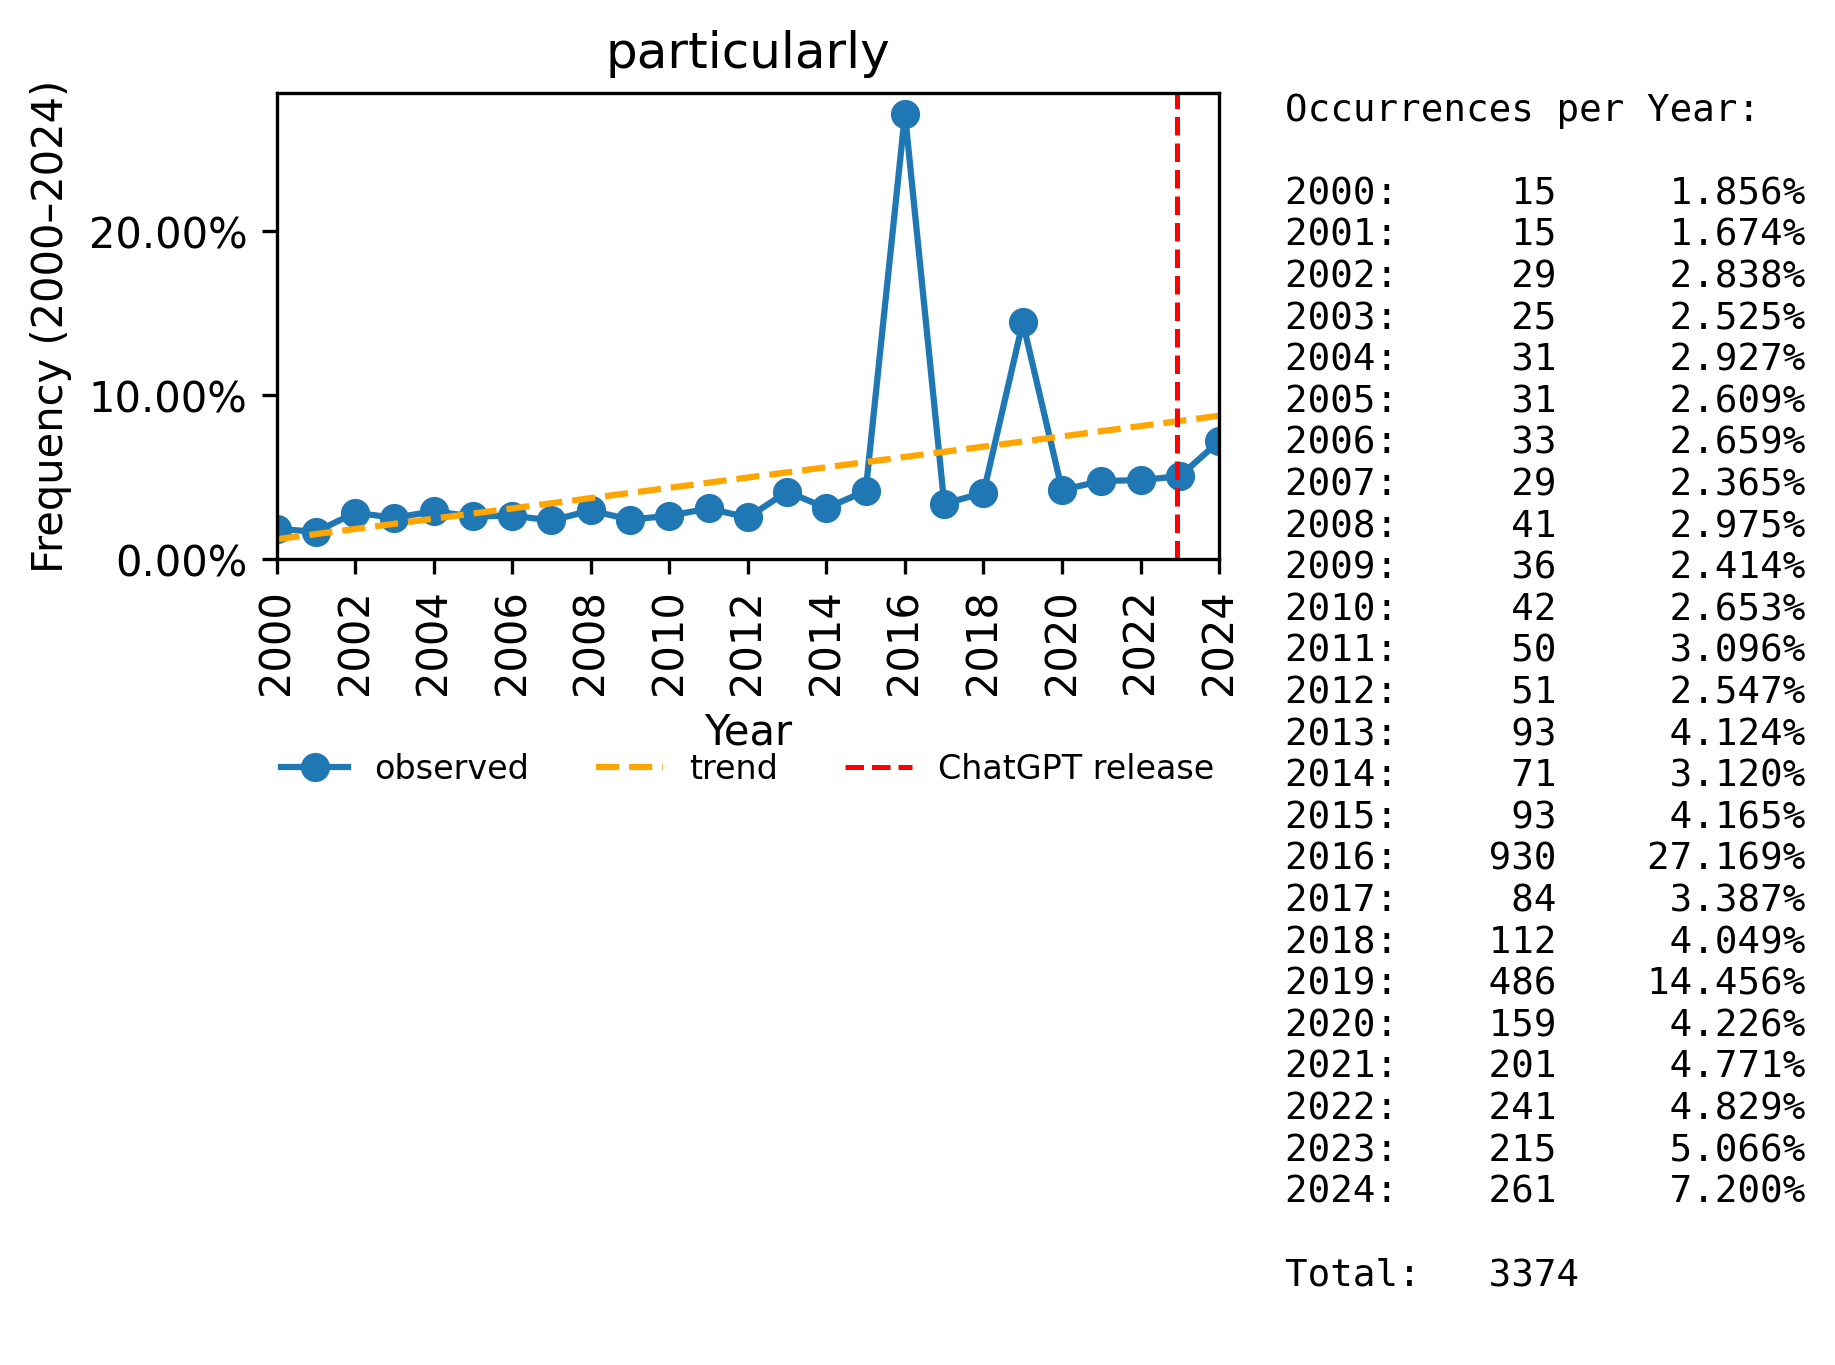

{'p': 0.072, 'q': 0.07546515329467678, 'delta': -0.0034651532946767816}

In [50]:
plot_word_timeseries(
  word="particularly", 
  occurence_freq=occurence_freq,
  occurrences_abs=occurence_counts,
  year_range=(2000, 2024),
  train_years=(2000, 2022),
  target_year=2024
)